# Pytorch Homework 3: 利用 stanford dog (mini) dataset 來訓練一個分類器。

## 作業說明

這次的作業總共有 4 個部份，必須完成助教提供的 ipynb 檔，在檔案中某些區塊會有 ??? 處需要完成。

0. 安裝需要使用的 package: pip install -r requirements.txt

1. 實作 Dataloader
    * 1.1. 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset。 ** (10%) **
    * 1.2. 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader  ** (15%) **

2. 建構 CNN model。
    * 2.1. 利用 Pytorch 內建的 CNN model 來進行訓練。 ** (10%) **
    * 2.2. 自行設計一個新的 CNN model 來進行訓練。 ** (20%) ** (至少達到 70% 以上的 Testing accuracy，否則只有一半的分數)
    * 2.3. 利用 torchsummary 來印出上面兩個模型的架構資訊。 ** (5%) **

3. 實作模型訓練和測試模型效能。 ** (30%) **
4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖並儲存下來。 ** (10%) **
    
## 作業繳交

* Deadline : 11/16 中午12:00        
    * **遲交一天打 7 折**
    * **遲交兩天打 5 折**
    * **遲交三天以上不給予分數**
    
* 繳交方式 : 請將完成的 ipynb 檔 (分成兩個版本: 內建 model 版和自己設計的版本) 以及 Loss、Training / testing accuracy 的圖片，壓縮後上傳至 moodle。
    * 建議先完成一個版本，然後將檔案複製後再完成另一個版本
    
* 壓縮檔內包含 :
    * (你的學號)\_(姓名)\_HW3_2_1.ipynb  (E.g.F77777777_王小明_HW3_2_1.ipynb) 
    * (你的學號)\_(姓名)\_HW3_2_2.ipynb  (E.g.F77777777_王小明_HW3_2_2.ipynb) 
    * 兩個版本的 Loss.png、Acc.png (Loss_2_1.png、Loss_2_2.png、Acc_2_1.png、Acc_2_2.png)
    * **格式不對的話會扣 10 分！！！**
    
* 有任何問題歡迎寄信至我的信箱
    * 曹維廷 a0903511820@gmail.com

In [ ]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torch.optim import lr_scheduler
from torchsummary import summary
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Part 1：Dataloader 實作

In [ ]:
# 1.1. 填入 ??? 的部份

class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)
        label = np.array(self.labels[idx])
                
        return image, label # return 模型訓練所需的資訊


In [ ]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# 1.2. 填入 ??? 的部份

def split_Train_Val_Data(data_dir):
    
    dataset = ImageFolder(data_dir) 
    
    # 建立 20 類的 list
    character = [[] for i in range(len(dataset.classes))]
    # print(character)
    
    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:
        character[y].append(x)
      
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        
        np.random.seed(42)
        np.random.shuffle(data)
            
        # -------------------------------------------
        # 將每一類都以 8:2 的比例分成訓練資料和測試資料
        # -------------------------------------------
        
        num_sample_train = 0.8
        num_sample_test = 0.2
        
        # print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))
        
        for x in data[:int(len(data)*num_sample_train)] : # 前 80% 資料存進 training list
            train_inputs.append(x)
            train_labels.append(i)
            
        for x in data[int(len(data)*num_sample_train):] : # 後 20% 資料存進 testing list
            test_inputs.append(x)
            test_labels.append(i)

    train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True, num_workers= 4)
    test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                  batch_size = batch_size, shuffle = False, num_workers= 4)
 
    return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

In [ ]:
# 2.2. 自行設計一個新的 CNN model

class BuildModel(nn.Module):

    def __init__(self):
        
        super(BuildModel, self).__init__()
        
        self.VGG16_form = [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"]
        self.in_channels = 3
        self.img_size = 224
        self.num_classes = 20
        self.conv_layers = self.build_conv_layers(self.VGG16_form)
        self.fully_connected_layers = nn.Sequential(
        nn.Linear(int(((self.img_size/32)**2)*512), 4096), #conv最後從(7 X 7 X 512)flatten為一維
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Dropout(p= 0.5),
        nn.Linear(4096,4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Dropout(p= 0.5),
        nn.Linear(4096, self.num_classes))
        
        
        # ----------------------------------------------
        # 初始化模型的 layer (input size: 3 * 224 * 224)
        # ----------------------------------------------
               
    def forward(self, x):
        
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fully_connected_layers(x)
        # ----------------------------------------------
        # Forward (最後輸出 20 個類別的機率值)
        # ----------------------------------------------
        return x
    
    def build_conv_layers(self, VGG_architecture): #建立VGG16架構
        layers = []
        in_channels = self.in_channels

        for layer_out in VGG_architecture: #針對vgg16的結構建立layers(list)
            if type(layer_out) == int:

                out_channels = layer_out

                layers += [nn.Conv2d(in_channels= in_channels, out_channels= out_channels,
                kernel_size=(3,3), stride=(1,1), padding=(1,1)),nn.BatchNorm2d(out_channels) ,nn.ReLU(True)]

                in_channels = out_channels #更新下一個layers的in_channel
            elif layer_out == 'M': #沒有參數
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride= (2,2))]
        return nn.Sequential(*layers)

### Setting

依據需求調整參數

In [ ]:
torch.cuda.empty_cache()

In [ ]:
batch_size = 64
lr = 1e-3
epochs = 20

data_dir = '/content/drive/My Drive/data/stanford_dog'

In [ ]:
# 2.3. 

train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

torch.cuda.empty_cache()

# C = BuildModel().to(device) # 使用內建的 model 或是自行設計的 model
C = models.resnet50(pretrained=True)
num_features = C.fc.in_features
C.fc = nn.Linear(num_features, 20)
C = C.to(device)

optimizer_C = optim.SGD(C.parameters(), lr = lr, momentum= 0.9, weight_decay= 0.0001) # 選擇你想用的 optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_C, step_size=10, gamma=0.1)
# optimizer_C = optim.Adam(C.parameters(), lr = lr) # 選擇你想用的 optimizer

# print(summary(C, (3,224,224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criterion = nn.CrossEntropyLoss()
 # 選擇想用的 loss function

In [ ]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

### 3. 實作模型訓練和測試模型效能

In [ ]:
def train():
  if __name__ == '__main__':
  
    for epoch in range(epochs):
      start = time.time()
      iter = 0
      correct_train, total_train = 0, 0
      correct_test, total_test = 0, 0
      train_loss_C = 0.0

      C.train() # 設定 train 或 eval
    
      print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
      
      # ---------------------------
      # Training Stage
      # ---------------------------
      
      for i, (x, label) in enumerate(train_dataloader) :
          # print('now is iteration :{}'.format(i),end='\r')
          iter_start = time.time()   

          x, label = x.to(device), label.to(device)
                      
          optimizer_C.zero_grad()
          input_start = time.time()
          outputs = C(x) # 將訓練資料輸入至模型進行訓練
          # print('network cal takes {:.2f} secs'.format(time.time()-input_start),end='\r')
          loss = criterion(outputs, label) # 計算 loss
          
          loss.backward() # 將 loss 反向傳播
          optimizer_C.step() # 更新權重
          
          # 計算訓練資料的準確度 (correct_train / total_train)
          _, predicted = torch.max(outputs.data,1)
          total_train += label.size(0)
          correct_train += (predicted == label).sum().item()

          train_loss_C += loss.item()
          iter += 1
          # print('this iter takes {:.2f} secs'.format(time.time()-iter_start),end='\r')
      exp_lr_scheduler.step()        
      print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
            (epoch + 1, train_loss_C / iter, correct_train / total_train))
      end = time.time()
      print('Training takes %.3f secs'%(end-start))
      
      # --------------------------
      # Testing Stage
      # --------------------------
      
      C.eval() # 設定 train 或 eval
        
      for i, (x, label) in enumerate(test_dataloader) :
        
          with torch.no_grad(): # 測試階段不需要求梯度
              x, label = x.to(device), label.to(device)
              
              outputs = C(x) # 將測試資料輸入至模型進行測試
  #                 ??? # 計算測試資料的準確度
              _, predicted = torch.max(outputs.data,1)
              total_test += label.size(0)
              correct_test += (predicted == label).sum().item()
      
      print('Testing acc: %.3f' % (correct_test / total_test))
                                    
      train_acc.append(100 *(correct_train / total_train)) # training accuracy
      test_acc.append(100 * (correct_test / total_test))  # testing accuracy
      loss_epoch_C.append(train_loss_C / iter) # loss 
  return 'finished'

epoch: 1 / 20
Training epoch: 1 / loss_C: 2.562 | acc: 0.311
Training takes 29.107 secs
Testing acc: 0.741
epoch: 2 / 20
Training epoch: 2 / loss_C: 1.551 | acc: 0.650
Training takes 29.391 secs
Testing acc: 0.837
epoch: 3 / 20
Training epoch: 3 / loss_C: 1.049 | acc: 0.733
Training takes 29.647 secs
Testing acc: 0.868
epoch: 4 / 20
Training epoch: 4 / loss_C: 0.830 | acc: 0.765
Training takes 30.169 secs
Testing acc: 0.879
epoch: 5 / 20
Training epoch: 5 / loss_C: 0.723 | acc: 0.786
Training takes 30.463 secs
Testing acc: 0.876
epoch: 6 / 20
Training epoch: 6 / loss_C: 0.640 | acc: 0.811
Training takes 30.475 secs
Testing acc: 0.888
epoch: 7 / 20
Training epoch: 7 / loss_C: 0.607 | acc: 0.817
Training takes 30.676 secs
Testing acc: 0.888
epoch: 8 / 20
Training epoch: 8 / loss_C: 0.570 | acc: 0.820
Training takes 30.735 secs
Testing acc: 0.891
epoch: 9 / 20
Training epoch: 9 / loss_C: 0.529 | acc: 0.837
Training takes 30.941 secs
Testing acc: 0.897
epoch: 10 / 20
Training epoch: 10 / l

In [ ]:
# train()

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

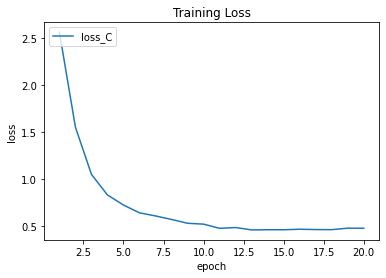

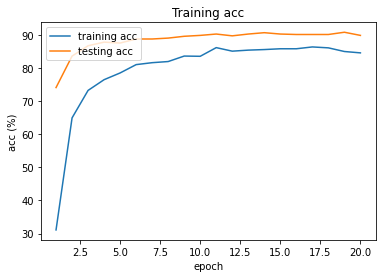

In [ ]:
plt.figure()

plt.plot(list(range(1,epochs+1)), loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.savefig('loss.jpg')
plt.show()

plt.figure()

plt.plot(list(range(1,epochs+1)), train_acc) # plot your training accuracy
plt.plot(list(range(1,epochs+1)), test_acc) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig('accu.jpg')
plt.show()

In [ ]:
# torch.save(C, 'ai_hw3.pt')